# Common

## Imports and Helper Function

In [2]:
# imports
import numpy as np
import math
np.random.seed(42)

# helper function
def print_matop(*matrices, separator="\t\t"):
    # Find the maximum number of rows across all matrices
    max_rows = max(len(matrix) for matrix in matrices)
    
    # Iterate over the rows by index up to the max number of rows
    for i in range(max_rows):
        formatted_rows = []
        for matrix in matrices:
            # Check if the matrix has a row at index i
            if i < len(matrix):
                row = matrix[i]
                # If row is iterable (like a list or numpy array), format each element
                if hasattr(row, '__iter__'):
                    formatted_rows.append("[" + " ".join(f"{val:2.2f}" for val in row) + "]")
                else:
                    # If it's a single scalar value, format it directly
                    formatted_rows.append(f"{row:2.2f}")
            else:
                # Add an empty value if the matrix does not have enough rows
                formatted_rows.append('\t')
        
        # Join the formatted rows with the specified separator and print them
        print(separator.join(formatted_rows))


## Toy Example

In [3]:
# SRAM memory size
M = 20
# simplified head size = hidden size
d = 2
# Sequence length
N = 6

# set block size for outer loop
Bc = math.ceil(M / (4 * d))
print(f"Bc: {Bc}")
# set block size for inner loop
Br = min(Bc, d)
print(f"Br: {Br}")

# Example dimensions for Q, K, V matrices
Q = np.random.randn(N, d)
K = np.random.randn(N, d)
V = np.random.randn(N, d)
with np.printoptions(precision=2, suppress=True):
    print(f"Q \t\t K \t\t V")
    for q, k, v in zip(Q, K, V):
        print(f"{q} \t {k} \t {v}")


Bc: 3
Br: 2
Q 		 K 		 V
[ 0.5  -0.14] 	 [ 0.24 -1.91] 	 [-0.54  0.11]
[0.65 1.52] 	 [-1.72 -0.56] 	 [-1.15  0.38]
[-0.23 -0.23] 	 [-1.01  0.31] 	 [-0.6  -0.29]
[1.58 0.77] 	 [-0.91 -1.41] 	 [-0.6   1.85]
[-0.47  0.54] 	 [ 1.47 -0.23] 	 [-0.01 -1.06]
[-0.46 -0.47] 	 [ 0.07 -1.42] 	 [ 0.82 -1.22]


## Ground Truth 1
- direct attention computation using numpy/scipy

In [4]:
import numpy as np
from scipy.special import softmax  # Optional, can use numpy's method or scipy's

def attention(Q, K, V):
    # Step 1: Calculate the dot product of Q and K.T (scores)
    S = np.dot(Q, K.T)  # (N, d) @ (d, N) -> (N, N)
    
    # Step 2: Apply the softmax to the scores for each row
    P = softmax(S, axis=1)  # Softmax along the rows
    
    # Step 3: Multiply the attention weights with the value matrix V
    O = np.dot(P, V)  # (N, N) @ (N, d) -> (N, d)
    
    return O

# Calculate the attention output
_O = attention(Q, K, V)

# Print the result
print("Attention Output O:")
with np.printoptions(precision=2, suppress=True):
    print(_O)


Attention Output O:
[[-0.17 -0.33]
 [-0.22 -0.7 ]
 [-0.41  0.14]
 [-0.03 -0.97]
 [-0.6   0.07]
 [-0.47  0.29]]


## Ground Truth 2

- manual implementation of classical attention computation

In [5]:
with np.printoptions(precision=2, suppress=True):

    S = Q @ K.T
    print('S:')
    print(S)

    m = np.max(S, axis=1, keepdims=True)
    print('\nm:')
    print(m)
    P = np.exp(S - m)
    print('\nP:')
    print(P)

    # Compute row sums of P_ij
    l = np.sum(P, axis=1, keepdims=True)
    print('l')
    print(l)

    A = P / l
    print('A')
    print(A)

    _O =  A @ V

    print(f"_O \t=\t A \t@\t V")
    print_matop(_O, A, V, separator='\t\t')


S:
[[ 0.38 -0.78 -0.55 -0.26  0.76  0.23]
 [-2.76 -1.97 -0.18 -2.74  0.61 -2.13]
 [ 0.39  0.54  0.16  0.54 -0.29  0.32]
 [-1.09 -3.16 -1.36 -2.52  2.14 -0.99]
 [-1.15  0.5   0.65 -0.34 -0.81 -0.8 ]
 [ 0.78  1.06  0.32  1.08 -0.57  0.63]]

m:
[[0.76]
 [0.61]
 [0.54]
 [2.14]
 [0.65]
 [1.08]]

P:
[[0.69 0.21 0.27 0.36 1.   0.59]
 [0.03 0.08 0.46 0.04 1.   0.07]
 [0.86 0.99 0.68 1.   0.43 0.8 ]
 [0.04 0.01 0.03 0.01 1.   0.04]
 [0.17 0.87 1.   0.37 0.23 0.23]
 [0.74 0.98 0.47 1.   0.19 0.64]]
l
[[3.13]
 [1.67]
 [4.77]
 [1.13]
 [2.87]
 [4.03]]
A
[[0.22 0.07 0.09 0.12 0.32 0.19]
 [0.02 0.05 0.27 0.02 0.6  0.04]
 [0.18 0.21 0.14 0.21 0.09 0.17]
 [0.04 0.   0.03 0.01 0.89 0.04]
 [0.06 0.3  0.35 0.13 0.08 0.08]
 [0.18 0.24 0.12 0.25 0.05 0.16]]
_O 	=	 A 	@	 V
[-0.17 -0.33]		[0.22 0.07 0.09 0.12 0.32 0.19]		[-0.54 0.11]
[-0.22 -0.70]		[0.02 0.05 0.27 0.02 0.60 0.04]		[-1.15 0.38]
[-0.41 0.14]		[0.18 0.21 0.14 0.21 0.09 0.17]		[-0.60 -0.29]
[-0.03 -0.97]		[0.04 0.00 0.03 0.01 0.89 0.04]		[-0.60 1

## Forward Pass With full decoder structure

In [6]:
import numpy as np

# Define LayerNorm function
def layer_norm(x, epsilon=1e-6):
    mean = np.mean(x, axis=-1, keepdims=True)
    variance = np.var(x, axis=-1, keepdims=True)
    normalized_x = (x - mean) / np.sqrt(variance + epsilon)
    return normalized_x

# Define the causal mask function
def causal_mask(S):
    mask = np.tril(np.ones_like(S), k=0)  # Lower triangular matrix with ones
    return np.where(mask == 0, -np.inf, S)

# Define the dropout function
def apply_dropout(P, p_drop):
    drop_mask = np.random.rand(*P.shape) > p_drop
    return P * drop_mask / (1 - p_drop)

# Assuming Q, K, V are already defined numpy arrays and d is the model dimension
τ = 1 / np.sqrt(Q.shape[1])
p_drop = 0.1  # Example dropout rate

# Apply Pre-LayerNorm to Q, K, V
Q_norm = layer_norm(Q)
K_norm = layer_norm(K)
V_norm = layer_norm(V)

with np.printoptions(precision=2, suppress=True):

    # Step 1: Apply scaling factor τ
    S = τ * Q_norm @ K_norm.T
    print('S (after scaling):')
    print(S)

    # Step 2: Apply causal mask
    Smasked = causal_mask(S)
    print('\nSmasked (after applying causal mask):')
    print(Smasked)

    # Step 3: Compute m and P
    m = np.max(Smasked, axis=1, keepdims=True)
    print('\nm:')
    print(m)
    P = np.exp(Smasked - m)
    print('\nP:')
    print(P)

    # Step 4: Apply dropout to P
    Pdropped = apply_dropout(P, p_drop)
    print('\nP_dropped (after applying dropout):')
    print(Pdropped)

    # Compute row sums of P_dropped
    l = np.sum(Pdropped, axis=1, keepdims=True)
    print('\nl (softmax denominator):')
    print(l)

    # Compute the attention matrix A
    A = Pdropped / l
    print('\nA (attention weights):')
    print(A)

    # Compute the output
    _O = A @ V_norm
    print(f"\n_O \t=\t A \t@\t V_norm")
    print_matop(_O, A, V_norm, separator='\t\t')


S (after scaling):
[[ 1.41 -1.41 -1.41  1.41  1.41  1.41]
 [-1.41  1.41  1.41 -1.41 -1.41 -1.41]
 [-0.01  0.01  0.01 -0.01 -0.01 -0.01]
 [ 1.41 -1.41 -1.41  1.41  1.41  1.41]
 [-1.41  1.41  1.41 -1.41 -1.41 -1.41]
 [ 1.07 -1.07 -1.07  1.07  1.07  1.07]]

Smasked (after applying causal mask):
[[ 1.41  -inf  -inf  -inf  -inf  -inf]
 [-1.41  1.41  -inf  -inf  -inf  -inf]
 [-0.01  0.01  0.01  -inf  -inf  -inf]
 [ 1.41 -1.41 -1.41  1.41  -inf  -inf]
 [-1.41  1.41  1.41 -1.41 -1.41  -inf]
 [ 1.07 -1.07 -1.07  1.07  1.07  1.07]]

m:
[[1.41]
 [1.41]
 [0.01]
 [1.41]
 [1.41]
 [1.07]]

P:
[[1.   0.   0.   0.   0.   0.  ]
 [0.06 1.   0.   0.   0.   0.  ]
 [0.98 1.   1.   0.   0.   0.  ]
 [1.   0.06 0.06 1.   0.   0.  ]
 [0.06 1.   1.   0.06 0.06 0.  ]
 [1.   0.12 0.12 1.   1.   1.  ]]

P_dropped (after applying dropout):
[[1.11 0.   0.   0.   0.   0.  ]
 [0.07 1.11 0.   0.   0.   0.  ]
 [0.   1.11 1.11 0.   0.   0.  ]
 [1.11 0.07 0.07 1.11 0.   0.  ]
 [0.07 1.11 0.   0.07 0.07 0.  ]
 [1.11 0.   0.

## Backward Pass

In [7]:
# Assuming _O and target (ground truth) are numpy arrays
target = np.random.randn(*_O.shape)  # Placeholder for the target matrix
L = np.mean((_O - target) ** 2)  # Mean Squared Error Loss

# Gradient of Loss with respect to _O
grad_O = 2 * (_O - target) / _O.size

# Backpropagate through A @ V
grad_A = grad_O @ V_norm.T
grad_V_norm = A.T @ grad_O

# Backpropagate through A = Pdropped / l
grad_Pdropped = grad_A / l
grad_l = -np.sum(grad_A * Pdropped / l**2, axis=1, keepdims=True)

# Backpropagate through P = exp(Smasked - m)
grad_Smasked = grad_Pdropped * Pdropped

# Backpropagate through m
grad_m = -np.sum(grad_Smasked, axis=1, keepdims=True)
grad_Smasked += grad_m

# Backpropagate through Smasked = MASK(S)
grad_S = grad_Smasked * (S != -np.inf)  # Masked gradients

# Backpropagate through S = τ * Q_norm @ K_norm.T
grad_Q_norm = τ * grad_S @ K_norm
grad_K_norm = τ * grad_S.T @ Q_norm

# Backpropagate through LayerNorm on Q, K, V
# Define a simple backward pass for LayerNorm
def layer_norm_backward(dout, x, epsilon=1e-6):
    mean = np.mean(x, axis=-1, keepdims=True)
    variance = np.var(x, axis=-1, keepdims=True)
    std_inv = 1. / np.sqrt(variance + epsilon)
    x_mu = x - mean
    dvar = np.sum(dout * x_mu, axis=-1, keepdims=True) * -.5 * std_inv**3
    dmean = np.sum(dout * -std_inv, axis=-1, keepdims=True) + dvar * np.mean(-2. * x_mu, axis=-1, keepdims=True)
    dx = (dout * std_inv) + (dvar * 2 * x_mu / x.shape[-1]) + (dmean / x.shape[-1])
    return dx

grad_Q = layer_norm_backward(grad_Q_norm, Q)
grad_K = layer_norm_backward(grad_K_norm, K)
grad_V = layer_norm_backward(grad_V_norm, V)

# At this point, grad_Q, grad_K, grad_V are the gradients of the loss with respect to the original inputs Q, K, V


In [29]:
def causal_mask(I):
    mask = np.tril(np.ones_like(I), k=0)  # Lower triangular matrix with ones
    O = np.where(mask == 0, -np.inf, I)   # Apply the mask
    return O, mask

def d_causal_mask(dO, mask):
    dI = dO * mask  # Propagate gradient only through unmasked elements (mask == 1)
    return dI

I = np.random.randn(4, 4)

# Forward pass
O, mask = causal_mask(I)
print("Forward Pass Output (O):")
print(O)

# Assume some gradient coming from the next layer
dO = np.random.randn(*O.shape)

# Backward pass
dI = d_causal_mask(dO, mask)
print("\nBackward Pass Output (dI):")
print(dI)
import numpy as np




Forward Pass Output (O):
[[-1.32023321        -inf        -inf        -inf]
 [-1.71313453  1.35387237        -inf        -inf]
 [-1.59442766 -0.59937502  0.0052437         -inf]
 [-0.45006547  0.62284993 -1.06762043 -0.14237949]]

Backward Pass Output (dI):
[[ 0.12029563  0.          0.         -0.        ]
 [-1.53411417  1.27767682  0.         -0.        ]
 [ 1.55115198  0.11567463  1.17929718  0.        ]
 [ 2.06074792  1.75534084 -0.24896415  0.97157095]]


In [32]:
def softmax(I: np.ndarray) -> np.ndarray:
    """
    I: (n, m)
    O: (n, m)
    """
    exp_I = np.exp(I - np.max(I, axis=1, keepdims=True))  # Subtract max for numerical stability
    O = exp_I / np.sum(exp_I, axis=1, keepdims=True)
    return O

def d_softmax(dO: np.ndarray, O: np.ndarray) -> np.ndarray:
    """
    dO: (n, m)
    O: (n, m)
    dI: (n, m)
    """
    n, m = O.shape
    dI = np.zeros_like(dO)

    for i in range(n):
        # Reshape O[i] to a column vector of shape (m, 1)
        O_i = O[i].reshape(-1, 1)
        # Compute the Jacobian matrix of the softmax function for this row, shape (m, m)
        jacobian_i = np.diagflat(O_i) - np.dot(O_i, O_i.T)
        # Compute the gradient for this row, shape (m,)
        dI[i] = np.dot(jacobian_i, dO[i])
    return dI

# Example input matrix I of shape (4, 4)
I = np.random.randn(4, 4)
print("I:")
print(I)
# Forward pass
O = softmax(I)
print("O:")
print(O)

# Assume some gradient coming from the next layer, of shape (4, 4)
dO = np.random.randn(*O.shape)
print("dO:")
print(dO)

# Backward pass
dI = d_softmax(dO, O)
print("dI:")
print(dI)

I:
[[ 1.68714164  0.88163976 -0.00797264  1.47994414]
 [ 0.07736831 -0.8612842   1.52312408  0.53891004]
 [-1.03724615 -0.19033868 -0.87561825 -1.38279973]
 [ 0.92617755  1.90941664 -1.39856757  0.56296924]]
O:
[[0.40928237 0.18289339 0.07513534 0.3326889 ]
 [0.13845177 0.05415604 0.58773596 0.21965624]
 [0.19172978 0.44719488 0.22536355 0.13571179]
 [0.22389644 0.59849772 0.02189895 0.15570689]]
dO:
[[-0.65064257 -0.48712538 -0.59239392 -0.86399077]
 [ 0.04852163 -0.83095012  0.27045683 -0.05023811]
 [-0.23894805 -0.90756366 -0.57677133  0.75539123]
 [ 0.50091719 -0.97755524  0.09933231  0.75138712]]
dI:
[[ 0.01501896  0.03661764  0.00713369 -0.05877028]
 [-0.00846181 -0.05093858  0.0945184  -0.03511801]
 [ 0.04605176 -0.1915893  -0.02200276  0.1675403 ]
 [ 0.19135461 -0.37335225  0.0099218   0.17207584]]


# Flash Attention 1

## Initialization

In [9]:
# Initialize output and intermediate arrays in HBM (using numpy arrays as example)
O = np.zeros((N, d))
l = np.zeros((N,1))
m = -np.inf * np.ones((N,1))
with np.printoptions(precision=2, suppress=True):
    print(f"O \t\t l \t m")
    for ro, rl, rm in zip(O, l, m):
        print(f"{ro} \t {rl} \t {rm}")

O 		 l 	 m
[0. 0.] 	 [0.] 	 [-inf]
[0. 0.] 	 [0.] 	 [-inf]
[0. 0.] 	 [0.] 	 [-inf]
[0. 0.] 	 [0.] 	 [-inf]
[0. 0.] 	 [0.] 	 [-inf]
[0. 0.] 	 [0.] 	 [-inf]


In [10]:
# Divide Q into Tr blocks of size Br x d
Tr = math.ceil(N / Br)
print(f"Tr:{Tr} = ceil(N:{N} / Br:{Br})")
Q_blocks = [Q[i:i + Br] for i in range(0, len(Q), Br)]
with np.printoptions(precision=2, suppress=True):
    print("Q_blocks:")
    for i, block in enumerate(Q_blocks):
        print(f"{i+1}th")
        print(block)

Tr:3 = ceil(N:6 / Br:2)
Q_blocks:
1th
[[ 0.5  -0.14]
 [ 0.65  1.52]]
2th
[[-0.23 -0.23]
 [ 1.58  0.77]]
3th
[[-0.47  0.54]
 [-0.46 -0.47]]


In [11]:
# Divide K, V into Tc blocks of size Bc x d
Tc = math.ceil(N / Bc)
print(f"Tc:{Tc} = ceil(N:{N} / Bc:{Bc})")

K_blocks = [K[i:i + Bc] for i in range(0, len(K), Bc)]
V_blocks = [V[i:i + Bc] for i in range(0, len(V), Bc)]
with np.printoptions(precision=2, suppress=True):
    print(f"K_block \t\t V_block")
    for i, _ in enumerate(K_blocks):
        print(f"{i+1}th")
        print_matop(K_blocks[i], V_blocks[i])

hbm = {
    'K_blocks': K_blocks,
    'V_blocks': V_blocks,
    'Q_blocks': Q_blocks,
    'O': O,
    'l': l,
    'm': m
}

Tc:2 = ceil(N:6 / Bc:3)
K_block 		 V_block
1th
[0.24 -1.91]		[-0.54 0.11]
[-1.72 -0.56]		[-1.15 0.38]
[-1.01 0.31]		[-0.60 -0.29]
2th
[-0.91 -1.41]		[-0.60 1.85]
[1.47 -0.23]		[-0.01 -1.06]
[0.07 -1.42]		[0.82 -1.22]


## Algorithm

### simplified
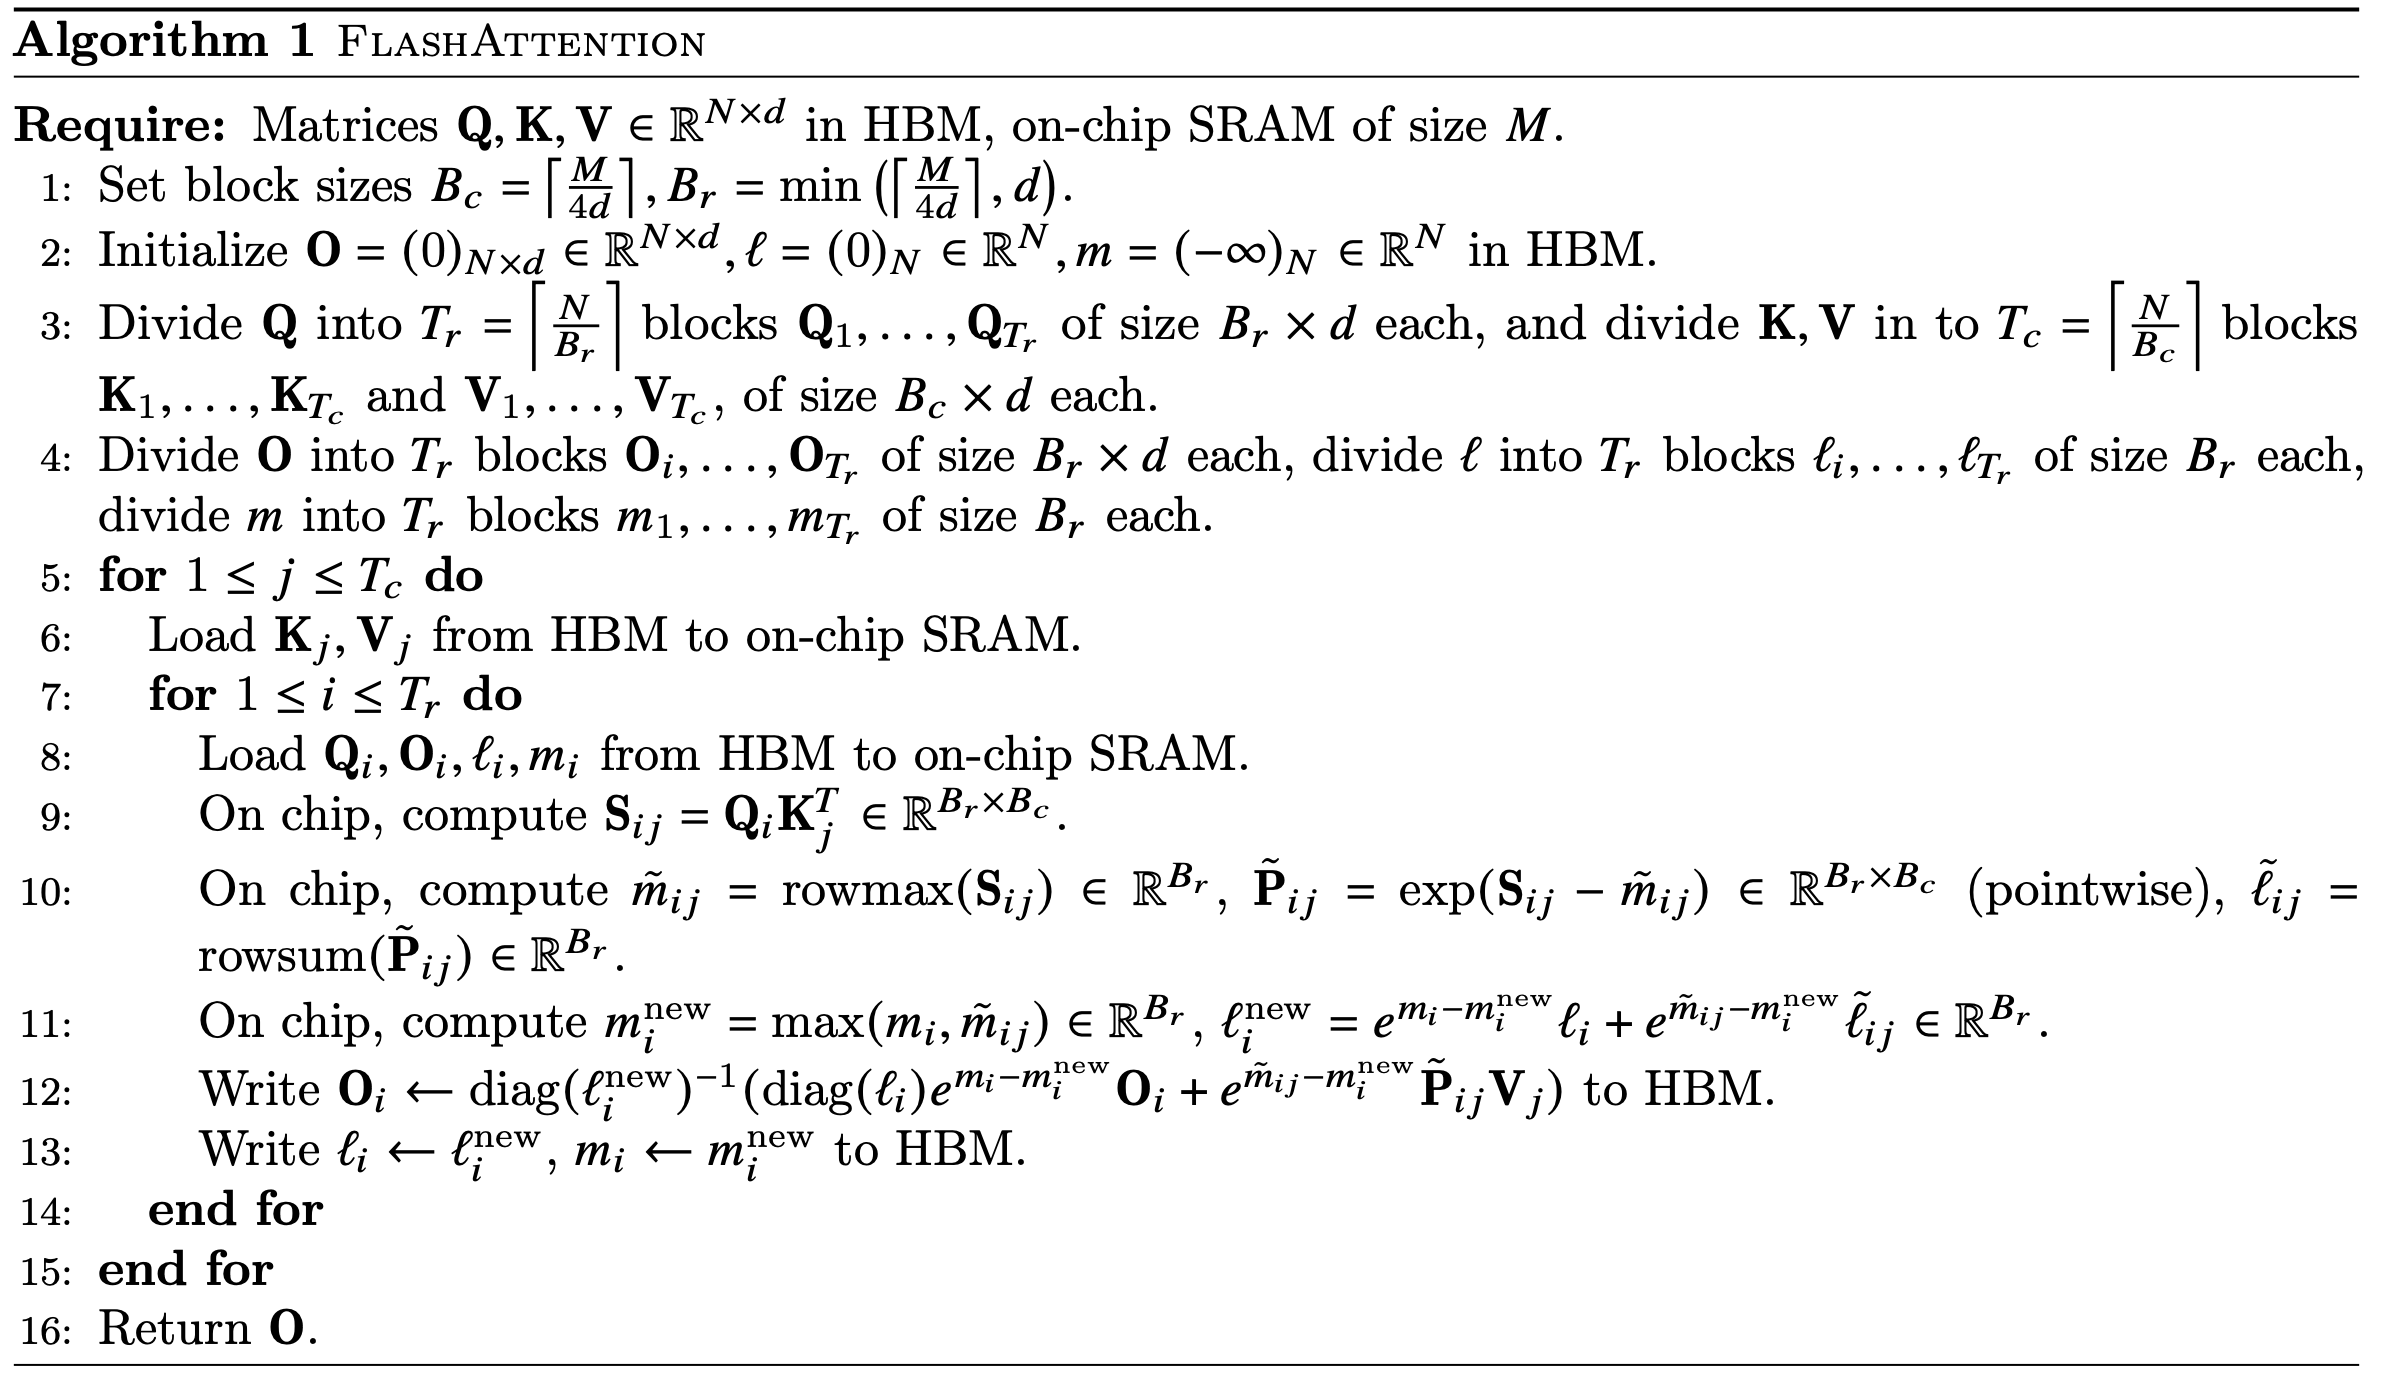

### detailed
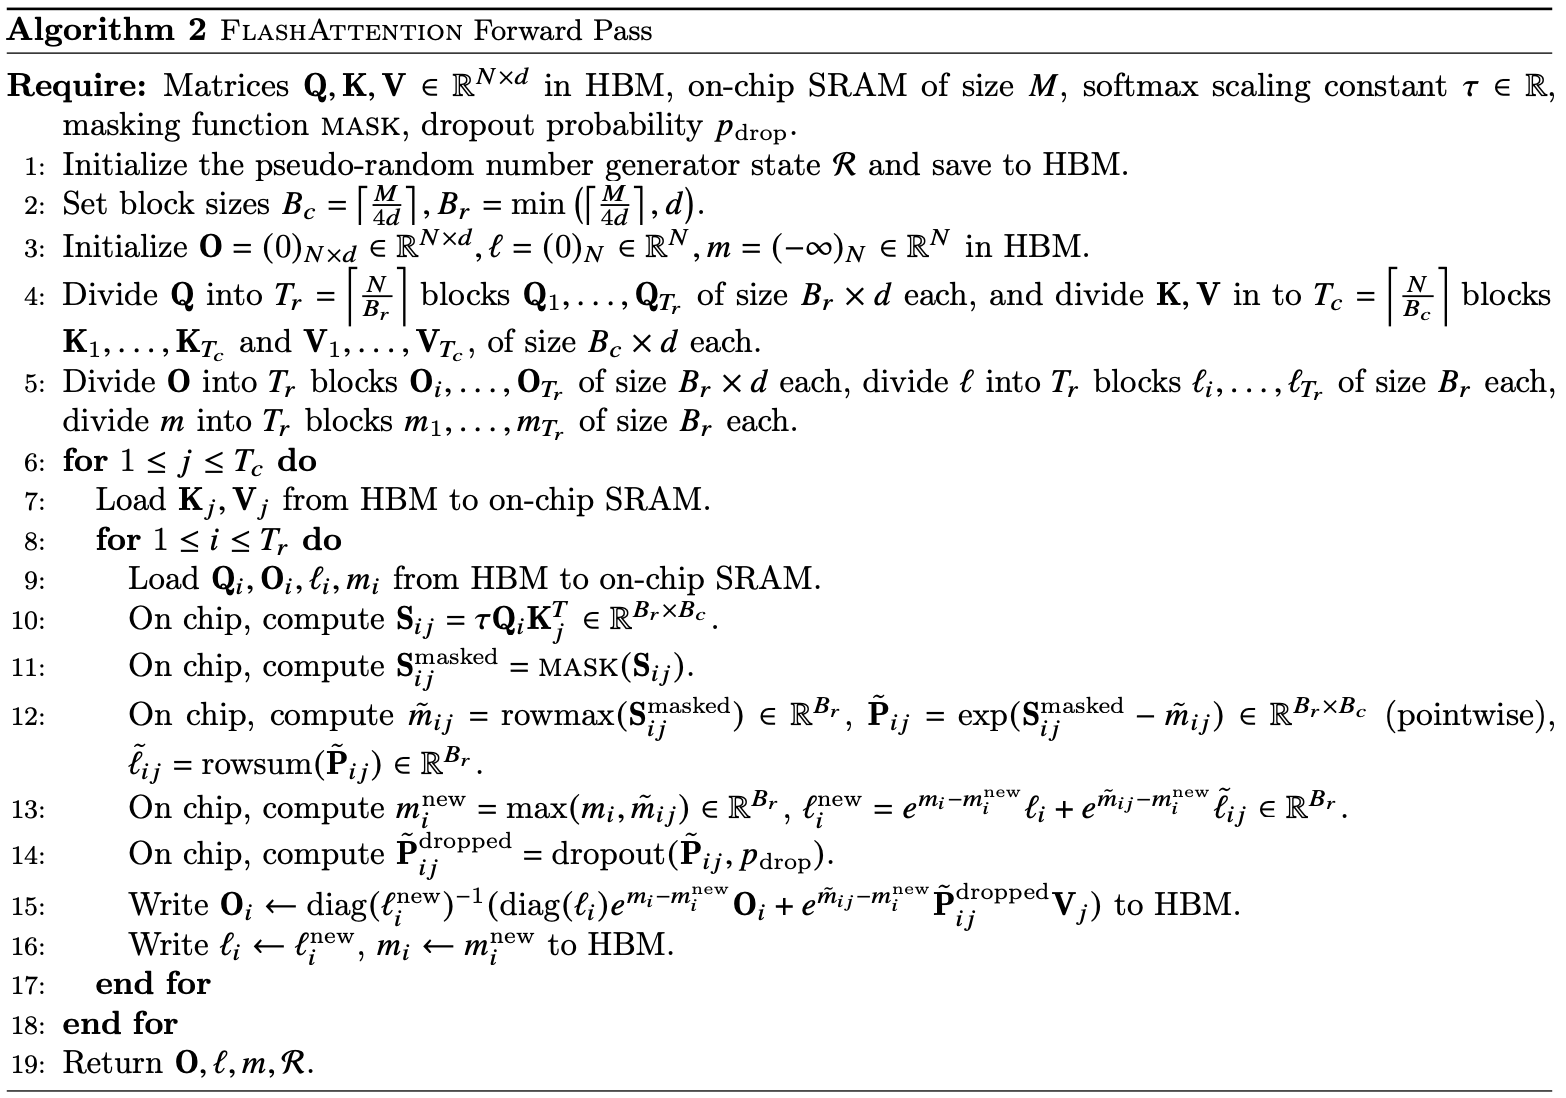

## Function

In [12]:

def inner_iter(i, j, hbm=hbm):
    K_blocks = hbm['K_blocks']
    V_blocks = hbm['V_blocks']
    Q_blocks = hbm['Q_blocks']
    O = hbm['O']
    m = hbm['m']
    l = hbm['l']

    with np.printoptions(precision=2, suppress=True):

        # Loop over K, V blocks (outer loop)
        Kj = K_blocks[j-1]
        Vj = V_blocks[j-1]
        # Loop over Q blocks (inner loop)
        Qi = Q_blocks[i-1]
        print()
        print('#' * 50)
        print(f"Processing blocks K{j} V{j} Q{i}")
        # print(f"K{j}(Bc, d) \t V{j}(Bc, d) \t Q{i}(Br, d)")
        # print_matop(Kj, Vj, Qi, separator='\t')

        # Compute Sij = Q_i * K_j^T
        Sij = Qi @ Kj.T
        print(f"local self attention dot-product:")
        print(f"S{i}{j}(Br, Bc) \t=\t Q{i}(Br, d) @\t K{j}^T (d, Bc):")
        print_matop(Sij, Qi, Kj.T, separator='\t')

        # Compute mij and exp(Sij - mij)
        mij = np.max(Sij, axis=1, keepdims=True)
        Sij_ = Sij - mij
        Pij = np.exp(Sij_)
        lij = np.sum(Pij, axis=1, keepdims=True)

        print(f"local row-wise max:")
        print(f"m{i}{j}(Br, 1) \t<=rowmax\t S{i}{j}(Br, Bc):")
        print_matop(mij, Sij, separator='\t\t\t\t')
        print(f"local softmax denominator:")
        print(f"l{i}{j}(Br, 1) \t<=rowsum\t P{i}{j}(Br, Bc) \t\t<=exp\t\t\t (S{i}{j} - m{i}{j}):")
        print_matop(lij, Pij, Sij_, separator='\t\t\t\t')

        Oi = O[(i-1)*Br:i*Br] # (Br, d)
        mi = m[(i-1)*Br:i*Br] # (Br, 1)
        li = l[(i-1)*Br:i*Br]  # (Br, 1)
        print(f'from HBM read in cumulative Output, Row_max and Softmax_denominator:')
        print(f'O{i} \t\t\t m{i} \t\t l{i}')
        print_matop(Oi, mi, li, separator='\t\t')

        # Update m_i_, l_i_
        mi_ = np.maximum(mi, mij)
        print(f"updated cumulative max:")
        print(f"m{i}_(Br,1) \t=\t max(m{i} \t,\t m{i}{j})")
        print_matop(mi_, mi, mij, separator='\t\t\t')

        past_scaled_l = np.exp(mi - mi_) * li
        local_l = np.exp(mij-mi_) * lij
        li_ = past_scaled_l + local_l
        print(f"updated cumulative softmax denominator:")
        print(f"l{i}_(Br,1) \t=\t exp(m{i}-m{i}_) \t*\t l{i} \t\t+\t exp(m{i}{j}-m{i}_) \t*\t l{i}{j}")
        print_matop(li_, np.exp(mi - mi_), li, np.exp(mij-mi_), lij, separator='\t\t\t')

        # Update O_i
        inv_li_ = np.diag(1.0 / li_.flatten())
        scaled_Oi = np.diag(li.flatten()) @ (np.exp(mi-mi_) * Oi)
        print(f"scaled cumulative Output of previous blocks, i.e. [from Q0 to Q{i-1}] @ K{j}.T @ V{j}")
        print(f"scaled_O{i} \t=\t diag(l{i}) \t@\t [exp(m{i}-m{i}_) \t*\t O{i}] \t=\t diag(l{i}) \t@\t [exp(m{i}-m{i}_)*O{i}]")
        print_matop(scaled_Oi, np.diag(li.flatten()), np.exp(mi-mi_), Oi, np.diag(li.flatten()), np.exp(mi-mi_)*Oi)

        scaled_PV = np.exp(mij - mi_) * Pij @ Vj
        print(f"scaled local P@V of current block")
        print(f"scaled_PV \t=\t exp(m{i}{j}-m{i}_) \t*\t [P{i}{j} \t\t@\t V{j}] \t=\t exp(m{i}{j}-m{i}_) \t*\t PV")
        print_matop(scaled_PV, np.exp(mij - mi_), Pij, Vj, np.exp(mij - mi_), Pij@Vj, separator='\t\t')

        Oi = inv_li_ @ (scaled_Oi + scaled_PV)
        print(f"updated cumulative Output of all blocks, i.e. [from Q0 to Q{i}] @ K{j}.T @ V{j}")
        print(f"O{i}_ (Br,d) \t=\t inv_l{i}_\t@\t (scaled_O{i}\t+\t scaled_PV)")
        print_matop(Oi, inv_li_, scaled_Oi, scaled_PV, separator='\t\t')

        # write out Oi to HBM
        hbm['O'][(i-1)*Br:i*Br] = Oi
        # write out li and mi to HBM
        hbm['l'][(i-1)*Br:i*Br] = li_
        hbm['m'][(i-1)*Br:i*Br] = mi_
        print(f'after saving O{i}, m{i}, l{i} to HBM')
        print(f"O \t\t\t m \t\t\t l ")
        print_matop(hbm['O'], hbm['m'], hbm['l'], separator='\t\t')

    return hbm


## Iterations

In [13]:
for j in range(1, len(K_blocks)+1, 1):
    for i in range(1, len(Q_blocks)+1, 1):
        hbm = inner_iter(i, j, hbm=hbm)


##################################################
Processing blocks K1 V1 Q1
local self attention dot-product:
S11(Br, Bc) 	=	 Q1(Br, d) @	 K1^T (d, Bc):
[0.38 -0.78 -0.55]	[0.50 -0.14]	[0.24 -1.72 -1.01]
[-2.76 -1.97 -0.18]	[0.65 1.52]	[-1.91 -0.56 0.31]
local row-wise max:
m11(Br, 1) 	<=rowmax	 S11(Br, Bc):
[0.38]				[0.38 -0.78 -0.55]
[-0.18]				[-2.76 -1.97 -0.18]
local softmax denominator:
l11(Br, 1) 	<=rowsum	 P11(Br, Bc) 		<=exp			 (S11 - m11):
[1.71]				[1.00 0.31 0.39]				[0.00 -1.16 -0.93]
[1.24]				[0.08 0.17 1.00]				[-2.58 -1.80 0.00]
from HBM read in cumulative Output, Row_max and Softmax_denominator:
O1 			 m1 		 l1
[0.00 0.00]		[-inf]		[0.00]
[0.00 0.00]		[-inf]		[0.00]
updated cumulative max:
m1_(Br,1) 	=	 max(m1 	,	 m11)
[0.38]			[-inf]			[0.38]
[-0.18]			[-inf]			[-0.18]
updated cumulative softmax denominator:
l1_(Br,1) 	=	 exp(m1-m1_) 	*	 l1 		+	 exp(m11-m1_) 	*	 l11
[1.71]			[0.00]			[0.00]			[1.00]			[1.71]
[1.24]			[0.00]			[0.00]			[1.00]			[1.24]
scaled cumul

# Flash Attention 2

## Initialization

In [14]:

with np.printoptions(precision=2, suppress=True):
    print(f"Q \t\t K \t\t V")
    for q, k, v in zip(Q, K, V):
        print(f"{q} \t {k} \t {v}")


Q 		 K 		 V
[ 0.5  -0.14] 	 [ 0.24 -1.91] 	 [-0.54  0.11]
[0.65 1.52] 	 [-1.72 -0.56] 	 [-1.15  0.38]
[-0.23 -0.23] 	 [-1.01  0.31] 	 [-0.6  -0.29]
[1.58 0.77] 	 [-0.91 -1.41] 	 [-0.6   1.85]
[-0.47  0.54] 	 [ 1.47 -0.23] 	 [-0.01 -1.06]
[-0.46 -0.47] 	 [ 0.07 -1.42] 	 [ 0.82 -1.22]


In [15]:
# # Initialize output and intermediate arrays in HBM (using numpy arrays as example)
# O = np.zeros((N, d))
# l = np.zeros((N,1))
# m = -np.inf * np.ones((N,1))
# with np.printoptions(precision=2, suppress=True):
#     print(f"O \t\t l \t m")
#     for ro, rl, rm in zip(O, l, m):
#         print(f"{ro} \t {rl} \t {rm}")

In [16]:
# Divide Q into Tr blocks of size Br x d
Tr = math.ceil(N / Br)
print(f"Tr:{Tr} = ceil(N:{N} / Br:{Br})")
Q_blocks = [Q[i:i + Br] for i in range(0, len(Q), Br)]
with np.printoptions(precision=2, suppress=True):
    print("Q_blocks:")
    for i, block in enumerate(Q_blocks):
        print(f"{i+1}th")
        print(block)

Tr:3 = ceil(N:6 / Br:2)
Q_blocks:
1th
[[ 0.5  -0.14]
 [ 0.65  1.52]]
2th
[[-0.23 -0.23]
 [ 1.58  0.77]]
3th
[[-0.47  0.54]
 [-0.46 -0.47]]


In [17]:
# Divide K, V into Tc blocks of size Bc x d
Tc = math.ceil(N / Bc)
print(f"Tc:{Tc} = ceil(N:{N} / Bc:{Bc})")

K_blocks = [K[i:i + Bc] for i in range(0, len(K), Bc)]
V_blocks = [V[i:i + Bc] for i in range(0, len(V), Bc)]
with np.printoptions(precision=2, suppress=True):
    print(f"K_block \t\t V_block")
    for i, _ in enumerate(K_blocks):
        print(f"{i+1}th")
        print_matop(K_blocks[i], V_blocks[i])

hbm = {
    'K_blocks': K_blocks,
    'V_blocks': V_blocks,
    'Q_blocks': Q_blocks,
    'O':np.zeros((N, d))
}

Tc:2 = ceil(N:6 / Bc:3)
K_block 		 V_block
1th
[0.24 -1.91]		[-0.54 0.11]
[-1.72 -0.56]		[-1.15 0.38]
[-1.01 0.31]		[-0.60 -0.29]
2th
[-0.91 -1.41]		[-0.60 1.85]
[1.47 -0.23]		[-0.01 -1.06]
[0.07 -1.42]		[0.82 -1.22]


## Algorithm

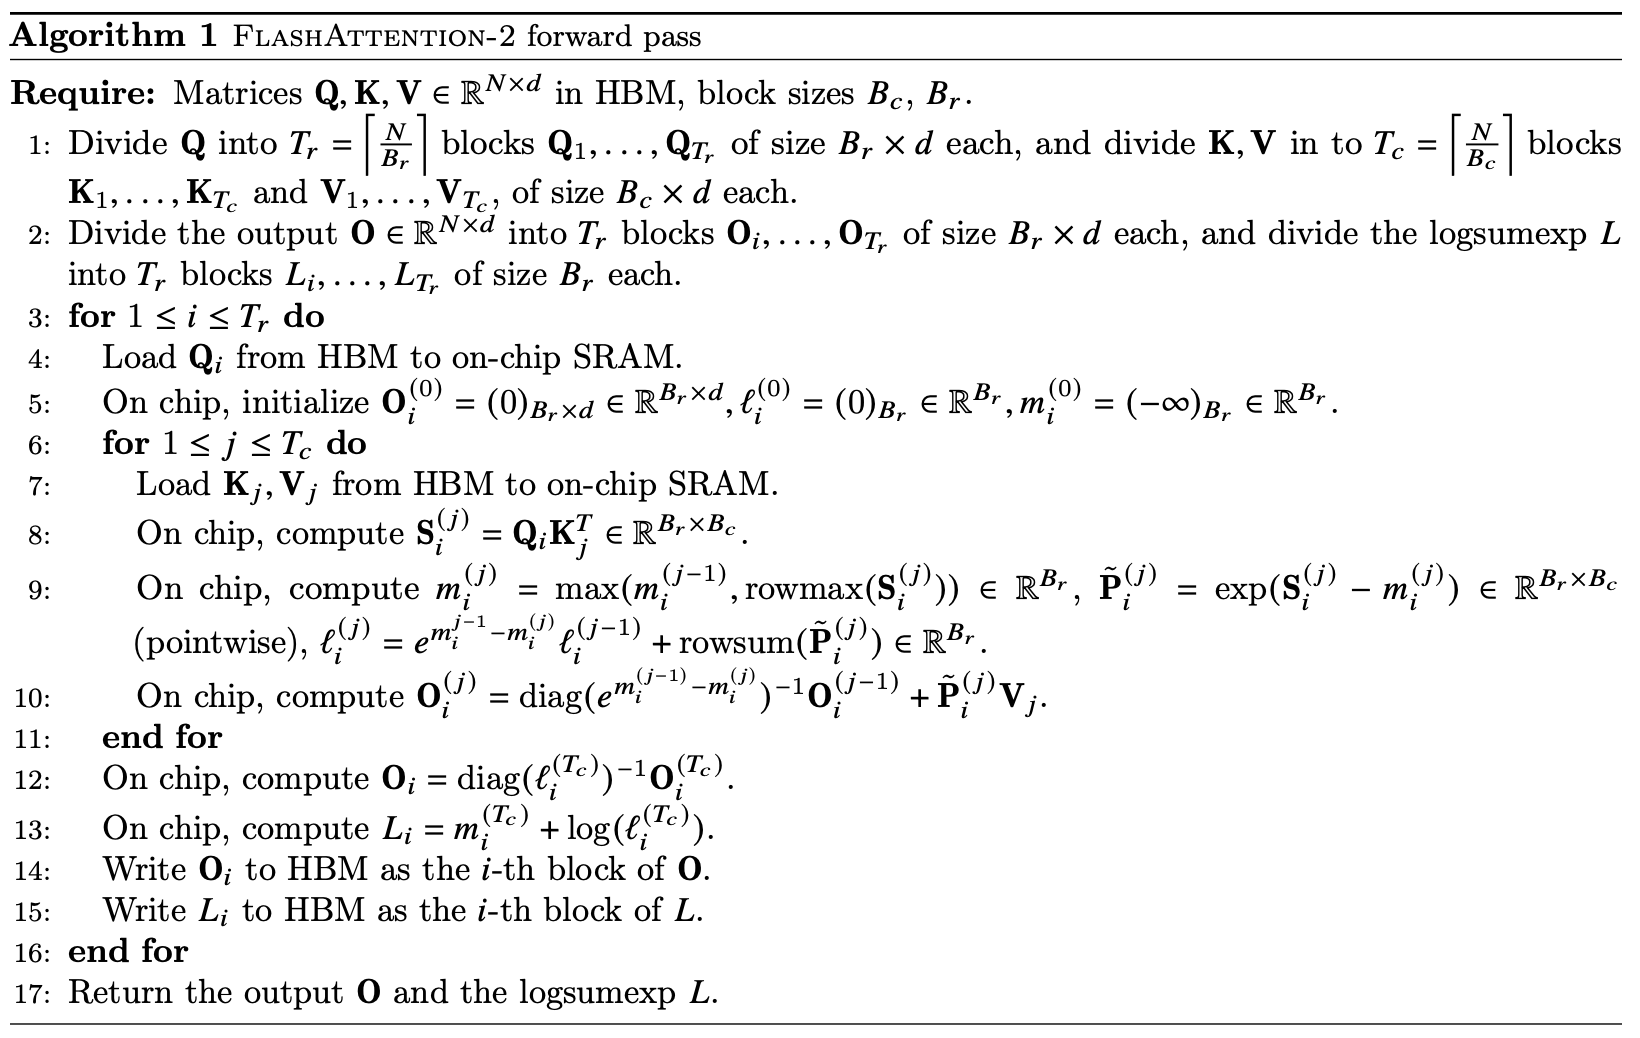

## Function

In [18]:
sram={}

def inner_iter(i, j, hbm=hbm, sram=sram):
    K_blocks = hbm['K_blocks']
    V_blocks = hbm['V_blocks']
    Q_blocks = hbm['Q_blocks']

    with np.printoptions(precision=2, suppress=True):
        # Load Q_i from HBM to on-chip SRAM
        Qi = Q_blocks[i-1]
        Kj = K_blocks[j-1]
        Vj = V_blocks[j-1]
        print('#' * 50)
        print(f"Processing blocks Q{i}, K{j}, V{j}")

        # Compute S_ij = Q_i * K_j^T
        Sij = Qi @ Kj.T
        print(f"S{i}{j}(Br, Bc) \t=\t Q{i}(Br, d) \t@\t K{j}^T (d, Bc):")
        print_matop(Sij, Qi, Kj.T, separator='\t')

        # Compute m_ij, exp(S_ij - m_ij), and l_ij
        mij = np.max(Sij, axis=1, keepdims=True)
        Sij_ = Sij - mij
        Pij = np.exp(Sij_)
        lij = np.sum(Pij, axis=1, keepdims=True)

        print(f"local row-wise max:")
        print(f"m{i}{j}(Br, 1) \t<=rowmax\t S{i}{j}(Br, Bc):")
        print_matop(mij, Sij, separator='\t\t\t\t')
        print(f"local softmax denominator:")
        print(f"l{i}{j}(Br, 1) \t<=rowsum\t P{i}{j}(Br, Bc) \t\t<=exp\t\t\t (S{i}{j} - m{i}{j}):")
        print_matop(lij, Pij, Sij_, separator='\t\t\t\t')

        # Retrieve previous values from SRAM
        Oi = sram['Oi']
        mi = sram['mi']
        li = sram['li']

        print(f'Continue from SRAM existing Output, Row_max and Softmax_denominator:')
        print(f'O{i} \t\t\t m{i} \t\t l{i}')
        print_matop(Oi, mi, li, separator='\t\t')

        # Update m_i
        mi_ = np.maximum(mi, mij)
        print(f"Updated cumulative max:")
        print(f"m{i}_(Br,1) \t=\t max(m{i} \t,\t m{i}{j})")
        print_matop(mi_, mi, mij, separator='\t\t\t')

        # Calculate li_ (new l_i)
        past_scaled_l = np.exp(mi - mi_) * li
        local_l = np.exp(mij - mi_) * lij
        li_ = past_scaled_l + local_l
        print(f"updated cumulative softmax denominator:")
        print(f"l{i}_(Br,1) \t=\t exp(m{i}-m{i}_) \t*\t l{i} \t\t+\t exp(m{i}{j}-m{i}_) \t*\t l{i}{j}")
        print_matop(li_, np.exp(mi - mi_), li, np.exp(mij-mi_), lij, separator='\t\t\t')

        # Update O_i
        inv_li_ = np.diag(1.0 / li_.flatten())
        scaled_Oi = np.diag(li.flatten()) @ (np.exp(mi-mi_) * Oi)
        print(f"scaled cumulative Output of previous blocks, i.e. [from Q0 to Q{i-1}] @ K{j}.T @ V{j}")
        print(f"scaled_O{i} \t=\t diag(l{i}) \t@\t [exp(m{i}-m{i}_) \t*\t O{i}] \t=\t diag(l{i}) \t@\t [exp(m{i}-m{i}_)*O{i}]")
        print_matop(scaled_Oi, np.diag(li.flatten()), np.exp(mi-mi_), Oi, np.diag(li.flatten()), np.exp(mi-mi_)*Oi)

        scaled_PV = np.exp(mij - mi_) * Pij @ Vj
        print(f"scaled local P@V of current block")
        print(f"scaled_PV \t=\t exp(m{i}{j}-m{i}_) \t*\t [P{i}{j} \t\t@\t V{j}] \t=\t exp(m{i}{j}-m{i}_) \t*\t PV")
        print_matop(scaled_PV, np.exp(mij - mi_), Pij, Vj, np.exp(mij - mi_), Pij@Vj, separator='\t\t')

        Oi_ = inv_li_ @ (scaled_Oi + scaled_PV)
        print(f"updated cumulative Output of all blocks, i.e. [from Q0 to Q{i}] @ K{j}.T @ V{j}")
        print(f"O{i}_ (Br,d) \t=\t inv_l{i}_\t@\t (scaled_O{i}\t+\t scaled_PV)")
        print_matop(Oi_, inv_li_, scaled_Oi, scaled_PV, separator='\t\t')

        # Retain the intermediate Oi, li, mi in SRAM
        sram['Oi'] = Oi_
        sram['li'] = li_
        sram['mi'] = mi_

    return hbm, sram

## Iteration

In [19]:
for i in range(1, len(Q_blocks) + 1):
    # reinitialize Oi, li, mi for each row i
    Oi = np.zeros((Br, d))
    li = np.zeros((Br,1))
    mi = -np.inf * np.ones((Br,1))
    sram = {
        'Oi': Oi,
        'li': li,
        'mi': mi}
    for j in range(1, len(K_blocks) + 1):
        hbm, sram = inner_iter(i, j, hbm=hbm, sram=sram)
    print(f"After processing row {i}")
    print(f"Save O{i} to HBM")
    hbm['O'][(i-1)*Br:i*Br] = sram['Oi']
    print_matop(hbm['O'])


##################################################
Processing blocks Q1, K1, V1
S11(Br, Bc) 	=	 Q1(Br, d) 	@	 K1^T (d, Bc):
[0.38 -0.78 -0.55]	[0.50 -0.14]	[0.24 -1.72 -1.01]
[-2.76 -1.97 -0.18]	[0.65 1.52]	[-1.91 -0.56 0.31]
local row-wise max:
m11(Br, 1) 	<=rowmax	 S11(Br, Bc):
[0.38]				[0.38 -0.78 -0.55]
[-0.18]				[-2.76 -1.97 -0.18]
local softmax denominator:
l11(Br, 1) 	<=rowsum	 P11(Br, Bc) 		<=exp			 (S11 - m11):
[1.71]				[1.00 0.31 0.39]				[0.00 -1.16 -0.93]
[1.24]				[0.08 0.17 1.00]				[-2.58 -1.80 0.00]
Continue from SRAM existing Output, Row_max and Softmax_denominator:
O1 			 m1 		 l1
[0.00 0.00]		[-inf]		[0.00]
[0.00 0.00]		[-inf]		[0.00]
Updated cumulative max:
m1_(Br,1) 	=	 max(m1 	,	 m11)
[0.38]			[-inf]			[0.38]
[-0.18]			[-inf]			[-0.18]
updated cumulative softmax denominator:
l1_(Br,1) 	=	 exp(m1-m1_) 	*	 l1 		+	 exp(m11-m1_) 	*	 l11
[1.71]			[0.00]			[0.00]			[1.00]			[1.71]
[1.24]			[0.00]			[0.00]			[1.00]			[1.24]
scaled cumulative Output of previous blocks,